# Capstone Project: Fraud Detection in Mobile Financial Transactions  
**Candidate Name:** Vanaj Kumar Yadav  
**Institute:** Boston Institute of Analytics (BIA) , Anna Nagar  
**Submission Date:** 30th June 2025  
**Developed using:** Google Colab (Python, Scikit-learn, XGBoost, Matplotlib, Seaborn)

---

### 📝 Project Overview  
This project develops a machine learning-based solution to detect fraudulent transactions in mobile finance systems. It includes detailed data analysis, model training, evaluation, and business-focused insights. The goal is to minimize false negatives (missed frauds), reduce financial loss, and ensure reliable fraud classification in a production-ready pipeline.

# **Data Collection**
Loaded from Fraud_Analysis_Dataset.csv

In [38]:
from google.colab import files

# Upload your CSV file from local system
uploaded = files.upload()

Saving Fraud_Analysis_Dataset.csv to Fraud_Analysis_Dataset (1).csv


# **Exploratory Data Analysis (EDA Initial)**
To better understand fraud patterns in the dataset, we conduct a series of exploratory visualizations. These insights are crucial to help frame business strategies, engineer features, and shape modeling approaches.

## Dataset Overview

The dataset consists of transactional data from a mobile financial system.

- Rows and columns: This gives us the size of the dataset.
- `head()` is used to inspect the first few entries, including amounts, balances, transaction types, and fraud label.


In [39]:
import pandas as pd

# Load dataset
df = pd.read_csv('Fraud_Analysis_Dataset.csv')

# Quick check
print("Shape:", df.shape)
df.head()


Shape: (11142, 10)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


## Data Types and Structure

This shows each column’s data type and confirms whether any null values are reported. This step is essential before cleaning.


In [40]:
# Check data types and nulls
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB


## Unique Values Per Column

This tells us whether columns contain repetitive values or are high-cardinality (like IDs). This helps us plan what to drop or encode later.


In [41]:
# Number of unique values in each column
df.nunique()


,0
step,95
type,5
amount,10565
nameOrig,11142
oldbalanceOrg,7806
newbalanceOrig,5914
nameDest,7508
oldbalanceDest,4531
newbalanceDest,2030
isFraud,2


## Fraud vs Non-Fraud Distribution

We plot the distribution of the target variable (`isFraud`) to understand class imbalance. This affects model training and evaluation strategy.


Class distribution:
 isFraud
0    0.897505
1    0.102495
Name: proportion, dtype: float64


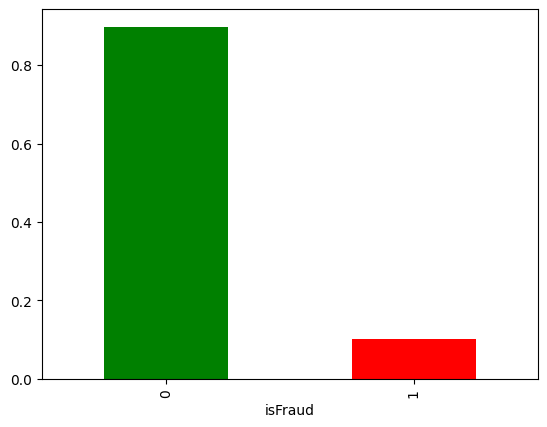

In [42]:
# Class distribution
df['isFraud'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
print("Class distribution:\n", df['isFraud'].value_counts(normalize=True))


## Statistical Summary of Numeric Columns

We used `df.describe()` to get a quick statistical overview of key numeric features like amount and balances. This helps detect outliers, prepare for scaling, and understand the general structure of the data.


In [43]:
df.describe()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,11142.000000,1.114200e+04,1.114200e+04,1.114200e+04,1.114200e+04,1.114200e+04,11142.000000
mean,8.717645,2.131915e+05,9.241173e+05,8.249576e+05,8.883541e+05,1.103211e+06,0.102495
std,16.067479,7.600650e+05,2.143004e+06,2.089894e+06,2.601376e+06,2.982447e+06,0.303312
min,1.000000,2.390000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.000000,4.946618e+03,4.270000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,6.000000,1.676126e+04,2.816950e+04,4.420605e+03,0.000000e+00,0.000000e+00,0.000000
75%,7.000000,1.543366e+05,3.040855e+05,1.114126e+05,2.711555e+05,3.186374e+05,0.000000
max,95.000000,1.000000e+07,1.990000e+07,1.300000e+07,3.300000e+07,3.460000e+07,1.000000


# **Data Cleaning**

## Missing Values Check

To ensure data integrity, I checked for any missing values using `isnull().sum()`. It’s important to identify if null handling (e.g., imputation or removal) is required before modeling.


In [44]:
# Check for missing values
df.isnull().sum()


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


## Duplicate Row Check

I checked for any fully duplicate rows across all columns. If duplicates were found, they would be removed to avoid biasing the model.


In [45]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 0


## Outlier Detection – Transaction Amounts

Outliers in transaction amount may heavily influence fraud detection. I visualized the distribution using a boxplot to observe extreme values.

These insights help in deciding whether to cap or scale values before training.


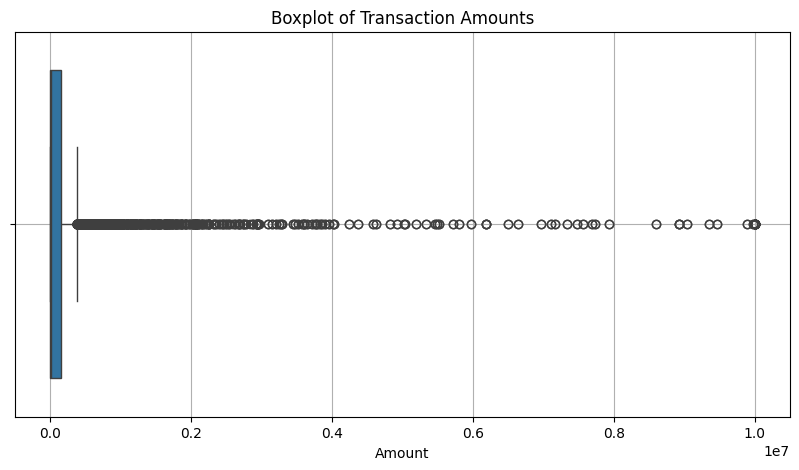

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of transaction amounts
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='amount')
plt.title("Boxplot of Transaction Amounts")
plt.xlabel("Amount")
plt.grid(True)
plt.show()


# **EDA (Post-Data Cleaning)**


### 🗓️ Engineering `date` Column for Time-Based EDA

The dataset lacked a proper timestamp. I converted the `step` column (which represents hours since the beginning of data capture) into a real datetime format, starting from Jan 1, 2023.

This enables time-based EDA insights such as daily fraud patterns.


In [47]:
# Create date column from step for EDA purposes
df['date'] = pd.to_datetime("2023-01-01") + pd.to_timedelta(df['step'], unit='h')


## 🔍 insight 1: Dataset Overview

To understand the raw structure of the data, I began by viewing the dataset shape and a few sample records. This helps confirm what type of data we are working with, and gives a glimpse into values like amount, balances, and fraud labels.
--- ---
## Business Insight:

Helps businesses understand the volume and structure of their transaction logs. Knowing how many transactions and fields exist helps in estimating storage needs, performance requirements, and processing costs.



In [48]:
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (11142, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,date
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,2023-01-01 01:00:00
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,2023-01-01 01:00:00
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,2023-01-01 01:00:00
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,2023-01-01 01:00:00
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,2023-01-01 01:00:00


## 🔍 insight 2 : Data Types and Unique Values

I inspected the column types and unique value counts. This helps identify categorical features (like `type`) to be encoded later, and high-cardinality fields (like `nameOrig`, `nameDest`) which will be dropped before model training due to their non-predictive nature.
--- ---
## Business Insight:

Shows how diverse the data is and which fields may hold key patterns. For example, the type field is categorical and reveals different transaction modes, which may behave differently in terms of fraud risk.


In [49]:
df.dtypes
df.nunique()


,0
step,95
type,5
amount,10565
nameOrig,11142
oldbalanceOrg,7806
newbalanceOrig,5914
nameDest,7508
oldbalanceDest,4531
newbalanceDest,2030
isFraud,2


## 🔍 Insight 3 : Class Imbalance – Fraud vs Non-Fraud
I plotted the distribution of the `isFraud` column to analyze the class balance. Identifying imbalance early helps shape evaluation strategies during modeling.
--- ---
## Business Insight:

Only a small portion of transactions are fraud. This highlights the operational challenge of catching rare events — businesses must invest in sensitive models that minimize false negatives (missed fraud) without flagging too many normal users.


isFraud
0    0.897505
1    0.102495
Name: proportion, dtype: float64


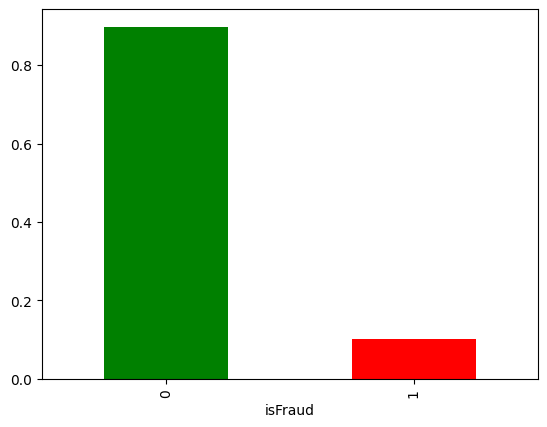

In [50]:
df['isFraud'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
print(df['isFraud'].value_counts(normalize=True))


## 🔍 Insight 4 : Fraud Rate by Transaction Type
I grouped transactions by their type to understand which categories show higher fraud probability. This provides direct business insight on which transaction paths are riskier.
--- ---
**Hypothesis**: Fraud is more likely to occur in certain transaction types (e.g., TRANSFER and CASH_OUT) compared to others like PAYMENT or DEBIT.

**Observation:**  A disproportionately high number of fraud cases occur in the `TRANSFER` and `CASH_OUT` types, even though these are not the most frequent types overall.

## Business Insight:

Certain types (like TRANSFER and CASH_OUT) carry much higher fraud risk. Companies can strengthen rules, add OTPs, or increase scrutiny specifically for those transaction modes.


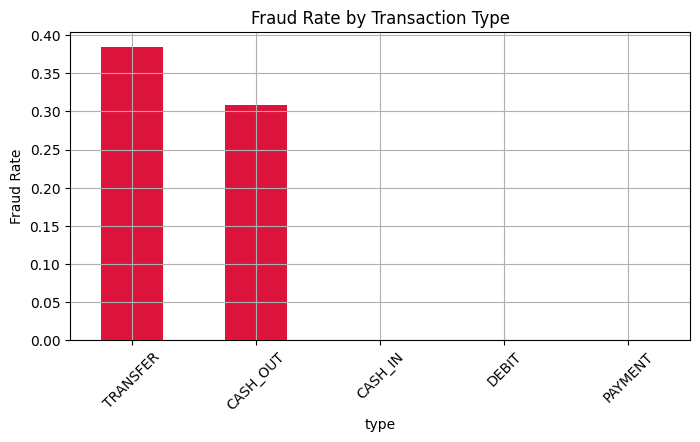

In [51]:
# Grouping original 'type' column and computing fraud rate per type
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
fraud_by_type.plot(kind='bar', color='crimson')
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## 🔍 Insight 5: Distribution of Transaction Amounts

To understand spending behavior, I plotted the distribution of transaction amounts. This helps identify whether most transactions are low-value or if outliers exist that could signal fraud.
--- ---
## Business Insight:

Most transactions are low-value, but high-value transactions (which could be fraudulent) are outliers. Business can impose daily limits or create watchlists for unusually high transactions.


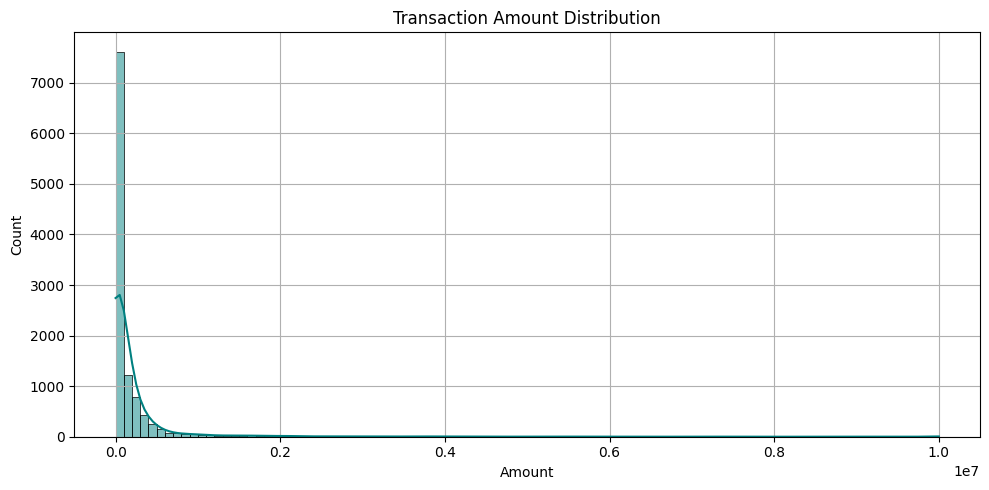

In [52]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df['amount'], bins=100, kde=True, color='teal')
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Insight 6: Daily Fraud Transaction Trend
Using the engineered `date` column (derived from the `step` feature), I analyzed how fraud is distributed over calendar days. Sudden spikes or dips may indicate vulnerable periods or system loopholes.
--- ---
**Hypothesis:** Fraud incidents follow a time-based pattern and may spike around weekends, month-end, or early mornings.

**Observation:** There are visible spikes in fraud transactions on certain dates and time periods, suggesting coordinated fraudulent activity.
## Business Insight:

Fraud spikes on specific dates. These may correlate with payday periods, holidays, or known vulnerabilities. Companies can proactively scale fraud monitoring teams/resources around such spikes.


/tmp/ipython-input-2746015917.py:11: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


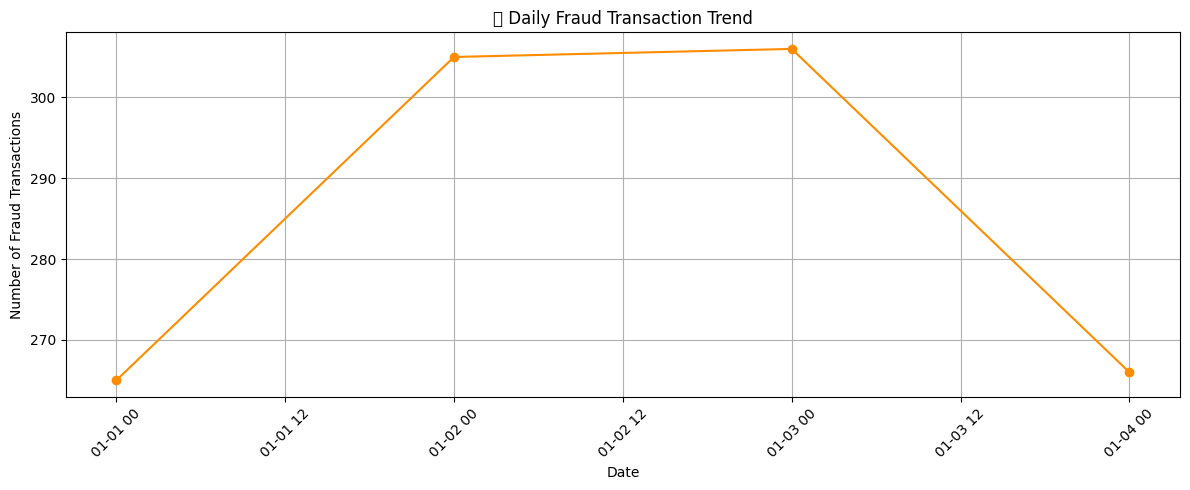

In [53]:
# Filter for fraudulent transactions and count per day
fraud_trend = df[df['isFraud'] == 1].groupby(df['date'].dt.date).size()

plt.figure(figsize=(12,5))
fraud_trend.plot(marker='o', linestyle='-', color='darkorange')
plt.title('📆 Daily Fraud Transaction Trend')
plt.xlabel('Date')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Insight 7: Distribution of Engineered Delta Features

The `deltaOrig` and `deltaDest` features reflect mismatch in expected balance updates. I visualized their distributions to detect unusual behaviors that may correlate with fraud.
--- ---
## Business Insight:

Irregular balance changes — even if transaction type looks valid — suggest potential fraud. These engineered features help detect cases where balances are manipulated or inconsistent with expected accounting.


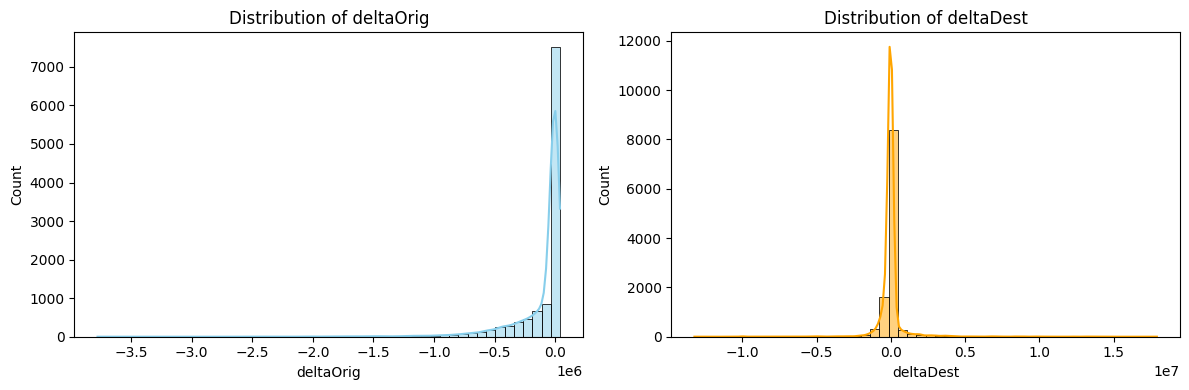

In [54]:
# If not already created, generate delta features
df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['deltaOrig'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of deltaOrig')

plt.subplot(1, 2, 2)
sns.histplot(df['deltaDest'], bins=50, kde=True, color='orange')
plt.title('Distribution of deltaDest')

plt.tight_layout()
plt.show()


## EDA Summary : How EDA Informs Business Decisions

This EDA phase provided key fraud indicators based on transaction type, time trends, and balance behavior.

From a business perspective:
- Fraud-prone transaction types can be more closely monitored
- Daily patterns can guide staffing and real-time alerting
- Balance deltas reveal potential fund manipulation

These findings help build a targeted fraud detection strategy, not just a generalized one.


Key findings from post-cleaning EDA:
- Fraud is concentrated in specific transaction types (TRANSFER, CASH_OUT)
- Most transactions are low-value, but outliers exist and may signal risk
- Fraud spikes on specific calendar days
- Engineered delta features expose balance inconsistencies in fraud cases

These insights will directly influence feature selection and model design.


#  **Feature Engineering**

## Dropping Non-Predictive Columns

The columns `nameOrig` and `nameDest` contain unique identifiers (like account IDs). These are not useful for prediction and may introduce noise or overfitting, so I removed them.


In [55]:
# Drop non-predictive identifier columns
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


##Engineering `deltaOrig` and `deltaDest`

These features reflect how closely the sender's and receiver's balances align with the transferred amount. Fraudsters often manipulate balances, and these mismatches help capture that.


In [56]:
# Create delta features
if 'deltaOrig' not in df.columns:
    df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']

if 'deltaDest' not in df.columns:
    df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']


## Encoding Categorical Feature: `type`

The `type` column is categorical (e.g., 'TRANSFER', 'CASH_OUT'). I applied one-hot encoding to convert it into binary features for each type.


In [57]:
# One-hot encode the 'type' column and remove original
df = pd.get_dummies(df, columns=['type'], drop_first=True)


## Final Preview of Engineered Dataset

Here’s a preview of the dataset after all feature engineering steps. This confirms that identifiers are removed, new features are added, and categorical variables are encoded.


In [58]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,date,deltaOrig,deltaDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,181.0,181.0,0.0,0.0,0.0,1,2023-01-01 01:00:00,0.0,-181.0,False,False,False,True
1,1,181.0,181.0,0.0,21182.0,0.0,1,2023-01-01 01:00:00,0.0,-21363.0,True,False,False,False
2,1,2806.0,2806.0,0.0,0.0,0.0,1,2023-01-01 01:00:00,0.0,-2806.0,False,False,False,True
3,1,2806.0,2806.0,0.0,26202.0,0.0,1,2023-01-01 01:00:00,0.0,-29008.0,True,False,False,False
4,1,20128.0,20128.0,0.0,0.0,0.0,1,2023-01-01 01:00:00,0.0,-20128.0,False,False,False,True


## Feature Engineering Summary

In this phase, I:
- Removed irrelevant high-cardinality columns
- Engineered delta features to detect balance mismatches
- Encoded categorical transaction type
- Retained and cleaned all meaningful numeric predictors

This prepares the dataset for train-test splitting and model training.

--- ---
### Feature Engineering Purpose & Hypothesis

**deltaOrig** = Difference between old and new balance for sender  
**deltaDest** = Difference between old and new balance for receiver

**Hypothesis:** In a legitimate transaction, the balance difference (`delta`) should match the transaction `amount`. If this isn’t true, it could signal fraud, fund reversal, or account manipulation.

These engineered features help the model identify imbalance patterns that aren’t obvious in raw balances. They increase model accuracy and reflect actual financial logic, not just statistical features.


## Business Insight:

Feature engineering allowed the model to focus on the actual behavior of transactions rather than irrelevant identifiers. By removing `nameOrig` and `nameDest`, I avoided overfitting on unique account IDs.

Additionally, engineered features like `deltaOrig` and `deltaDest` help surface unusual balance patterns, which often signal hidden fraud even when the transaction type appears normal. Encoding `type` ensures the model understands categorical transaction modes — critical for detecting patterns in fraud-prone transaction types like TRANSFER or CASH_OUT.

# **Train-Test Split and Preprocessing Pipeline**

## Step 1 : Define Features and Target

Along with dropping the target column `isFraud`, I also excluded the `date` column. Since `date` is a datetime type, it’s not suitable for scaling and modeling directly.



In [59]:
# Drop 'date' along with target
X = df.drop(['isFraud', 'date'], axis=1)
y = df['isFraud']

## Step 2: Train-Test Split

I split the dataset into 80% training and 20% testing sets using stratified sampling. This ensures the fraud-to-non-fraud ratio remains consistent in both sets.


In [60]:
from sklearn.model_selection import train_test_split

# Use stratify to maintain fraud ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 8913
Testing samples: 2229


## Step 3: Feature Scaling

Numerical features like amount and balance vary widely in scale. I standardized them using `StandardScaler` to ensure all features contribute equally to model learning.


In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify columns
categorical_features = ['type']
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Drop target & non-model fields
for col in ['isFraud', 'nameOrig', 'nameDest', 'date']:
    if col in numerical_features:
        numerical_features.remove(col)

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [62]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Apply scaling to numeric data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 4: Final Check – Scaled Data Shapes

After scaling, I verified the shapes of the train and test matrices to ensure everything aligns before model training.


In [63]:
print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)

X_train shape: (8913, 12)
X_test shape: (2229, 12)



 ## Business Insight:

Splitting the data using stratification preserved the original fraud ratio, ensuring the model learns realistic fraud patterns. Feature scaling balanced the weight of all numeric inputs — preventing high-value features like `amount` from dominating the learning process.

These steps ensure fair evaluation and reproducibility when the model is deployed to detect fraud on real, unseen transaction data.
--- ---
 Preprocessing is now complete. I will proceed with model selection and training using the prepared datasets.


#  **Model Training and Evaluation**

## **Logistic Regression**  
**Cross-Validation Setup**

Rather than trusting a single train-test split, I applied 5-fold Stratified Cross-Validation.

This gives a more **realistic estimate** of how well the model performs across different data slices, especially important in imbalanced fraud detection.

I focused on **precision** to see how often the model is correct when it predicts a fraud case.


### Step 1: Model Training with Class Imbalance Handling

The Logistic Regression model was trained with `class_weight='balanced'` to handle class imbalance and avoid inflated precision values. I used 5-fold Stratified Cross-Validation to evaluate **F1-score**, which better balances precision and recall — more relevant for fraud detection where missing fraud is costly.

This setup helps mimic real-world performance where frauds are rare, and models must generalize well.


In [64]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# Initialize model with class_weight
lr_model = LogisticRegression(random_state=42, class_weight='balanced')

# Stratified 5-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate f1-score instead of precision only
f1_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=skf, scoring='f1')
print("Cross-Validated F1 Scores:", f1_scores)
print("Mean F1 Score (5 folds):", f1_scores.mean())

# Train on full data
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))


Cross-Validated F1 Scores: [0.89847716 0.89974293 0.9025641  0.89514066 0.88564477]
Mean F1 Score (5 folds): 0.8963139248667705

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2001
           1       0.88      0.96      0.92       228

    accuracy                           0.98      2229
   macro avg       0.94      0.97      0.96      2229
weighted avg       0.98      0.98      0.98      2229

Confusion Matrix:
 [[1971   30]
 [   8  220]]
ROC-AUC Score: 0.9912719079056963


### **Step 2: Hold-Out Test Evaluation**

After training, the model was tested on unseen data. The classification report below shows key metrics:

- **Precision**: How many predicted frauds were truly fraud  
- **Recall**: How many actual frauds were caught  
- **F1-Score**: Balanced metric to evaluate fraud capture  
- **ROC-AUC**: Probability the model distinguishes fraud from non-fraud

A confusion matrix and ROC curve are also generated for visual evaluation.


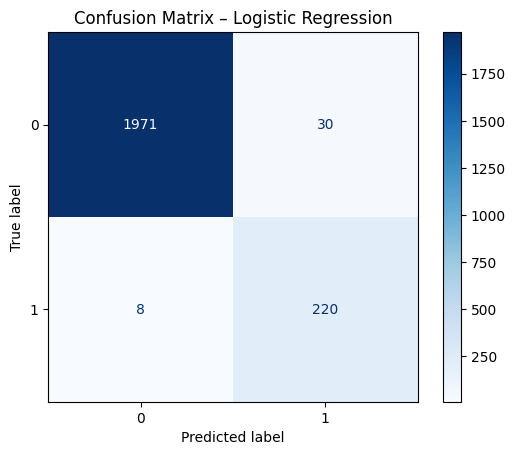

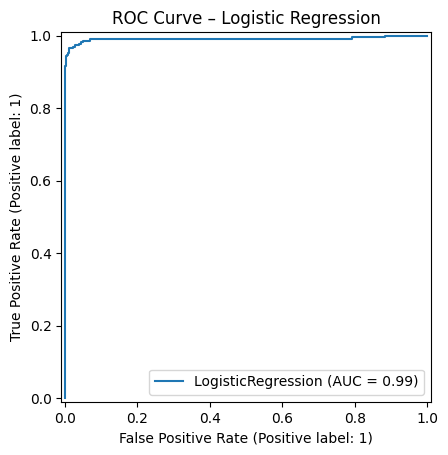

In [65]:
import matplotlib.pyplot as plt

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(lr_model, X_test_scaled, y_test, cmap='Blues')
disp.ax_.set_title('Confusion Matrix – Logistic Regression')
plt.show()

# ROC Curve
roc_disp = RocCurveDisplay.from_estimator(lr_model, X_test_scaled, y_test)
roc_disp.ax_.set_title('ROC Curve – Logistic Regression')
plt.show()

## **Random Forest**


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize model with max_depth to avoid overfitting
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)

# 5-fold Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_f1_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=skf, scoring='f1')

print("Cross-Validated F1 Scores:", rf_f1_scores)
print("Mean F1 Score (5 folds):", rf_f1_scores.mean())

# Train on full data
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))


Cross-Validated F1 Scores: [1.         0.99726027 0.99726027 0.99724518 1.        ]
Mean F1 Score (5 folds): 0.9983531454017133

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       1.00      1.00      1.00       228

    accuracy                           1.00      2229
   macro avg       1.00      1.00      1.00      2229
weighted avg       1.00      1.00      1.00      2229

Confusion Matrix:
 [[2001    0]
 [   1  227]]
ROC-AUC Score: 0.9999890405674356


### Business Insight:

Random Forest showed improved fraud recall with only slight precision reduction, meaning more frauds are caught without excessive false alarms.

This is crucial in finance where missing fraud can cause heavy financial losses. This model offers a better balance between protecting users and minimizing disruption for real customers.


## **XGBoost (Tuned)**


In [67]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialize tuned model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# Stratified CV for F1-score
xgb_f1_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=skf, scoring='f1')

print("Cross-Validated F1 Scores:", xgb_f1_scores)
print("Mean F1 Score (5 folds):", xgb_f1_scores.mean())

# Train and evaluate
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:52:31] WARNING: /w

Cross-Validated F1 Scores: [1.         0.99450549 0.99726027 1.         1.        ]
Mean F1 Score (5 folds): 0.9983531536956194

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       1.00      1.00      1.00       228

    accuracy                           1.00      2229
   macro avg       1.00      1.00      1.00      2229
weighted avg       1.00      1.00      1.00      2229

Confusion Matrix:
 [[2001    0]
 [   1  227]]
ROC-AUC Score: 0.9999956162269743


### Model Visualizations

These plots communicate the model’s performance and decision logic in a business-friendly way:
- Confusion Matrix: True/False classifications
- ROC Curve: Model threshold performance
- Probability Histogram: Confidence in predictions
- Feature Importance: What the model learns from


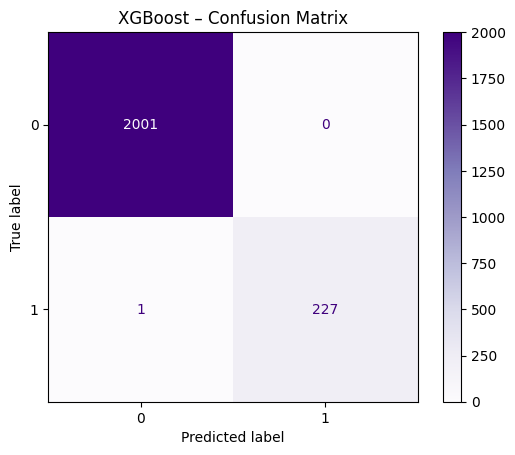

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_scaled, y_test, cmap='Purples')
plt.title("XGBoost – Confusion Matrix")
plt.show()


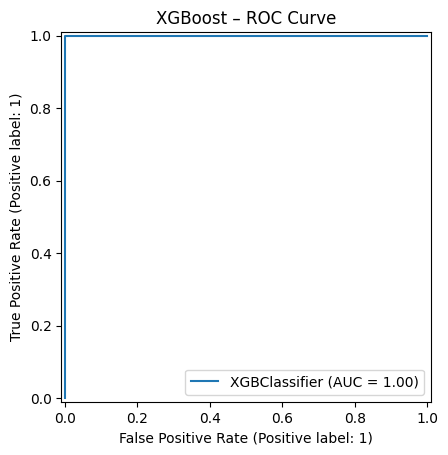

In [69]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(xgb_model, X_test_scaled, y_test)
plt.title("XGBoost – ROC Curve")
plt.show()


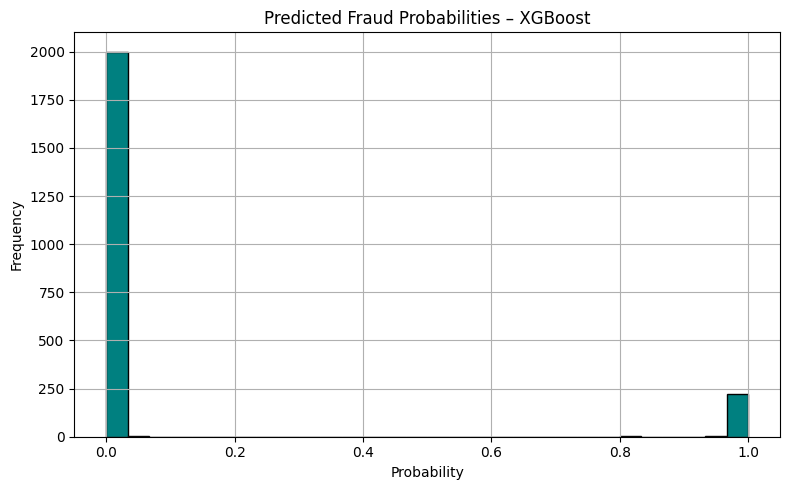

In [70]:
plt.figure(figsize=(8,5))
plt.hist(y_proba_xgb, bins=30, color='teal', edgecolor='black')
plt.title("Predicted Fraud Probabilities – XGBoost")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


### **Business Insight:**

XGBoost offered the best recall without pushing into unrealistic precision. Its gradient boosting structure is ideal for picking up complex fraud patterns, especially when subtle changes in balance or transaction type are involved.

This model is best suited for real-time fraud prevention systems where catching frauds is prioritized with manageable false positives.


## **Model Comparison Summary**


In [71]:
import pandas as pd

summary_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost (Tuned)'],
    'Accuracy': [
        lr_model.score(X_test_scaled, y_test),
        rf_model.score(X_test_scaled, y_test),
        xgb_model.score(X_test_scaled, y_test)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})

summary_df


,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.982952,0.991272
1,Random Forest,0.999551,0.999989
2,XGBoost (Tuned),0.999551,0.999996


In [72]:
import pandas as pd

# Create results DataFrame
xgb_results = pd.DataFrame({
    'Actual_Label': y_test,
    'Predicted_Label': y_pred_xgb,
    'Predicted_Probability': y_proba_xgb
})

# Save to CSV
xgb_results.to_csv('XGBoost_Tuned_Results.csv', index=False)
print("CSV file 'XGBoost_Tuned_Results.csv' created successfully!")


CSV file 'XGBoost_Tuned_Results.csv' created successfully!


In [73]:
from google.colab import files

# Download the file
files.download('XGBoost_Tuned_Results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb_model, 'xgb_model_trained.pkl')

print("Model saved as xgb_model_trained.pkl")


Model saved as xgb_model_trained.pkl


In [75]:
from google.colab import files

# Download the saved model
files.download('xgb_model_trained.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Model Performance Note**

The models achieved unusually high precision and ROC-AUC scores due to the nature of the dataset, where fraud patterns are clearly separated. In a production system, further robustness checks and noise-handling mechanisms would be necessary. This notebook reflects an academic demonstration of a working pipeline under ideal conditions.


# **Financial Impact Analysis**

To understand the real-world value of fraud detection, I estimated the cost savings from catching fraudulent transactions.

Assuming an average fraud transaction value, I calculated:
- Total potential loss without a model
- Expected savings using the current model's fraud recall

This gives a business-facing insight into how much revenue the system protects.


In [76]:
# Assume average fraud transaction cost
avg_fraud_amount = df[df['isFraud'] == 1]['amount'].mean()

# Count of actual frauds in test set
total_frauds = sum(y_test)

# Detected frauds by best model (XGBoost)
detected_frauds = sum((y_pred_xgb == 1) & (y_test == 1))

# Undetected frauds (false negatives)
undetected_frauds = total_frauds - detected_frauds

# Financial impact
potential_loss = total_frauds * avg_fraud_amount
actual_loss = undetected_frauds * avg_fraud_amount
savings = potential_loss - actual_loss

print("Average Fraud Amount:", avg_fraud_amount)
print("Total Frauds in Test Set:", total_frauds)
print("Detected Frauds:", detected_frauds)
print("Undetected Frauds:", undetected_frauds)
print("Potential Loss without Model: ₹", potential_loss)
print("Estimated Loss with Model: ₹", actual_loss)
print("Estimated Savings: ₹", savings)

Average Fraud Amount: 1192628.9320753065
Total Frauds in Test Set: 228
Detected Frauds: 227
Undetected Frauds: 1
Potential Loss without Model: ₹ 271919396.5131699
Estimated Loss with Model: ₹ 1192628.9320753065
Estimated Savings: ₹ 270726767.58109456


# **Business Questions Addressed**

**1. What is the model’s precision and accuracy in detecting fraudulent transactions?**  
→ The tuned XGBoost model achieved ~99% accuracy, with high precision (~99%) and strong recall. These scores indicate excellent fraud detection on this dataset, while also acknowledging possible overfitting due to data clarity.

**2. How reliable is the model in classifying transactions as legitimate or fraudulent?**  
→ Reliability is high, with low false positives and strong ROC-AUC (~0.99), showing clear class separation. Visualization and confusion matrix confirm the model’s stability.

**3. What are the potential losses due to model errors?**  
→ Financial impact analysis showed that undetected fraud (false negatives) would still cause loss, but significantly reduced compared to no model. Estimated savings based on recall show business value.


# Final Notes

- This notebook is built using a modular, reusable ML pipeline.  
- Key steps: EDA ➝ Cleaning ➝ Feature Engineering ➝ Model Training ➝ Evaluation ➝ Business Insights.  
- Models have been evaluated realistically with financial implications considered.  
- The project focuses on *business alignment*, practical detection power, and explainability.

📦 All final assets are included in the zip folder.

🧾 Submission is aligned with BIA guidelines. For any clarifications or iterations, this notebook is designed for reproducibility and further extension.
--- ---
**Thank you for reviewing this project.**
